**Problem Statement and General Idea:** The goal of the problem is to maximize net profit from a marketing campaign for fundraising. 
Since the response rate is low (about 5 percent), it is necessary to devise a strategy to identify profitable candidates.
Given a candidate-member *x*, I want to predict:

1. whether *x* will donate? 
*  what amount will *x* donate? 

Then, the expected revenue earned from *x* is:

$$ \text{E[Revenue | x]}  = \text{Prob[will donate? = Yes | x]} * \text{E[Amount | x]} $$ where prob[.] denotes probability and E[.] denotes expectation

I model these two *outcome* | *x* relationships on R.H.S. with ML models:
* First, I build a classification model using labelled training-data where label is binary 0/1 *outcome* 'TARGET_B' indicating whether member will donate. 
* Second, I build a regression model using provided training-data containing donation amounts 'TARGET_D' as the *outcome*.

I will evaluate these component models 1, 2 using classic ML metrics. The **full** scoring model will multiply predictions from models 1 and 2 to generate a profitability score for each candidate. Once, I have such model I can score all potential candidates, sort by score and retain all candidates scoring above a threshold. All members scoring above threshold are sent marketing materials. The full model will be evaluated using the target-business metric of 'direct profit.'   

All my models should beat a baseline "random" model.

Below are the main steps in the **data-mining pipeline**:

 
###Steps for Data Preparation:
    
***Data ingestion:*** The data-type for each attribute is already provided in feature_types.txt, I use those entries and build a feature to a reasonable python dtype map.
This map is used while loading the data from csv file. This will ensure some consistency in data-types.

***Data Imputation:*** After reading just the first few rows of data, I notice that there a lot of missing entries (NaNs). While some algorithms (like tree-based) can handle NaNs, missing data can create problems downstream. So, it is nice to populate mssing data as below:
1. for continuous values (floats) e.g. ethnic percentages in area, use population-median i.e. middle-value  
* for categories (object or ints), e.g. rating, use population-mode i.e. most-frequent value
* for items related to promotion history (given amounts and promotion/giving dates ) use 0s if missing [this is important 
because historical promotion data maybe very useful to indicate future donations and populating using approaches 1 or 2 (i.e. median or mode) will be incorrrect for those who never donated].

***Data cleaning and pre-processing:***
1. *Handling Categorical Attributes:*
Thankfully, a lot of ordered categorical attributes e.g 'WEALTH' rating have already been mapped to 'Num' in the mapping file feature_types.txt and hence, are stored as floats while loading data. So, I don't need to worry too much about these.
For unordered attributes, I can transform categorical features into binary 0/1 features via one-hot-encoding. Obviously, this blows up the dimensionality of the feature-space.
*  *Handling Zip Code:* 'ZIP' appears to be the feature with highest dimensionality (about 15K unique codes). First, I clean some bad zip codes (containing hyphen). Then, I truncate the 'ZIP' string to retain only first two digits (two or three digits is a choice and can be a hyperparameter that can be tuned) and use this coarse feature. This reduces the dimensionality of the feature space from ~15K to just a handful while retaining the location information e.g. code '92' covers some counties on pacific coast in CA spreading from 'orange county' to 'san diego.'
    
***Feature Selection:*** Feature-space is high-dimensional. It will be important to:
1. reduce dimensionality 
* avoid overfitting (use regularized models to control model complexity)

I use a three-phase approach to cut-down the dimensionality of feature-space:

1. *Handling Sparsity:*  First, I remove all binary features that are > 99.9% sparse in both the positive-set (people who donated) and negative-set (people who didn't). I am unlikely to learn any strong patterns from these binary features.
* *Univariate Feature Filtering:*
Secondly, given a feature *f*, I can compare mean(*f*) within these two groups. Then, I apply a t-test and compare *p-value* (or the absolute values of t-statistics) for each feature as a measure of how effective it is at separating groups. For continuous features like 'AGE' a t-test is sufficient.
After applying the t-test, I note that top few features separating the groups are - CARDGIFT, NGIFTALL, RDATE and LASTDATE.  This seems to confirm the hypothesis that future giving potential is tightly correlated with "historical giving history."
    
    For binary (0/1) features a permutation-test or chi-squared test is more appropriate (here I test for differences in average-count across two groups). After applying the t-test and permutation-test, I retain all features that have p-values < 0.2 i.e. have strong discriminative power at 80% confidence level. This seems to cut-down the feature-space by half.
* *Feature importances with forests of trees: * Finally, I fit an unparameterized random forest to full feature-set and pick the top-K features based on variable importance.

The final feature-set is selected as the union of features obtained from above steps 1,2 and 3.

***Feature Scaling and Transformations:***

1. *Feature Transformation:* I check distribution of population variable which I expect to be long-tailed and I apply log-transform to normalize. It looks like the raw target variable (donation_amount) seems to follow a long-tailed distribution. It is useful to transform Y via a log-transform and squish down the tail.
In general, to model a nice linear functional relationship Y | X, it is nice to have Y normally distributed. Otherwise, linear regression may seem to fit a linear function with high R-squared but in reality either 1) there is no linear relationship or 2) the model fit is sub-optimal due to presence of outliers (long-tails). https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Anscombe%27s_quartet_3.svg

* *MinMax Scaling:* At, the end I apply a min-max scaling transformation to all features. Scaling is always a nice idea because 1) ML algorithms are based on notion of distance between points and separating data. I don't want any feature to dominate this distance just because of scale of feature and 2) The optimization algorithms for these models rely on minimizing the loss-function in paramter-space. It is nice to have bowl-shaped functions to ensure quick convergence. This function can become skewed and ellipsoidal (when features are correlated/unscaled) leading to ill-conditioned hessian causing convergence issues.




After data preparation, I split data via 70-30 train-test split and get ready for modeling.



###Model Development:

As suggested earlier, I  develop two constituent models:
1. Classification: Predict Donors
* Regression: Predict Donation Capacity (amount)

***Model Considerations:***
1. **Model Regularization:** Since, feature space is quite high-dimensional, it is important to avoid overfitting and let the model select a small set of strong predictors.  All models tried have some flavor of regularization. 
I tried a variety of regularization constants and applied regularization to in different ways (i.e., L1/L2 logistic-regression, depth of tree-based models, dropout layer to neural networks) to improve the performance of the classifier.

* **Hyperparameter tuning:**
The classifier can perform poorly when trained with an arbitary set of hyperparameters. For each model, I experimented with a number of hyperparameters, for example, max_depth, max_features and n_estimaors for a random-forest and compared the cross-validation performance on training-set. Training ran fairly quickly on the relatively small data set, so I was able to test many combinations of hyperparameters. I used a greedy search (via Bayesian Optimization) to quickly move through the (large) space of possible hyperparameters and converged on the best combination. These hyperparameters listed only had a small effect on the results. 

* **Weight Balancing:** All classification models have some notion of 'class_weight' to automatically correct for unbalanced classes. This ensures that a misclassification of positive-example is penalized more heavily than one of negative-example.


***Model Selection:***
I try a variety of ML algorithms from childhood days (logistic regression, kNN) to teenage years (SVM, Random-Forest, Gradient-Boosting) to current state-of-the-art (neural networks). I use the following libraries - scikit (for most models), XGBoost (for regularized gradient boosting) and Keras (for implementing a neural network with single hidden layer and a dropout layer).

***Input Data for Modeling:***

1. Classification Model: Model selection and hyperparameter tuning are time consuming processes as they involve multiple passes over data ~100K examples. Instead of using all examples for these steps, I use - all available positive examples (P) 
AND undersample negative examples (sample only P negative examples) to build a balanced-training-set.
    
    After model selection and tuning, I pass the selected+tuned model over full training data with weight balancing as described in the section.

2. Regression Model: Once I predict the donors using the classfication, I want to develop a way to score their donation capacity. I use the available training-data containing non-zero donation-amounts.


***Experimental Evaluation:***
1. ***Model Evaluation Metrics:*** I use the typical metrics to evaluate classification/regression:
    * Classification: AUC/ROC Curve/Precision-Recall Curve
    * Regression: R-squared

* ***Business Evaluation Metric:*** A business use-case of the model is to score all members in set using the model and pick top-K (or ones scoring above a threshold) for sending marketing materials. Then, I can compute 'direct profit' resulting from top-K selection (or all above a threshold selection) using the predictions of trained-model on the test-set and compare to a random-selection. Mathematically, direct profit given as set $S$ is selected for sending marketing material costing $C$ dollars per packet:
$$ \text{direct profit given } S = \sum_{x \in S}{\text{probability of positive response ($x$)}*\text{expected donation amount ($x$)}} - C*K$$
I also evaluate constituent classification and regression models separately with certain assumptions. For example, when evaluating the classification model, I can assume a scenario where donation-amount is constant, AND when evaluating regression model, assume a scenario where everyone is equally likely to donate. Finally, I evaluate the combined scoring model.





###Conclusion/Future Directions:

**Conclusion:**

* Feature selection indicates that some top attributes driving a donation are attributes related to previous donation and promotion history.
* Classification Model (for probability prediction) Choice: After experimental comparison, tree based algorithms seems to be doing well which makes sense because I am able to learn non-linear interactions between features. Single layer Neural-network seems to be performing poorly which makes sense because they generally required a very high data/features ratio. Adding more layers may help but for now I choose xgboost for training-speed and specify the tuned parameters for performance. 
* Regression Model (for amount prediction) Choice: Random-Forest regression tree heavily outperforms L1/L2 linear regression models. I  use this as the model of choice for the amount prediction problem. So, full model looks like this:

    Full Model = XGBoostClassifer [Predict Donor or Not] + RandomForestRegressor[Predict Amount]

* After analyzing the performance of full-model on test-set (see plot below), it appears if I choose a scoring threshold corresponding to approximately top-50% (score > 1.2), I will maximize profit. I use the model and make predictions on the validation set using this threshold.

** Future Work:**
* Instead of using first two-digits of ZIP as a coarse location feature it maybe useful to perform spatial clustering on zip-codes based on eucledian distance between codes. For example, I could perform spectral clustering using a similarity metric: $sim(ZIP_A, ZIP_B) = 1 - dist(ZIP_A, ZIP_B)/\max_{\forall X,Y} dist(ZIP_X, ZIP_Y)$
* As demonstrated by high performance of tree-based models, it is useful to learn non-linear interactions between the features. In addition,  feature-feature similarity matrix exposes that there is still potential to reduce dimensionality and capture additional feature-feature interactions. Spectral clustering on features to introduce non-linear interactions between features could be useful.
* Calibrating the predicted score using a sigmoid or other monotonically increasing function so that predicted score  translates to real revenue 'TARGET_D'. This was considered not important as the goal metric doesn't really care about closeness of predictions to real donation amounts.
* Do more feature-engineering! Focus on features that are more important than others.

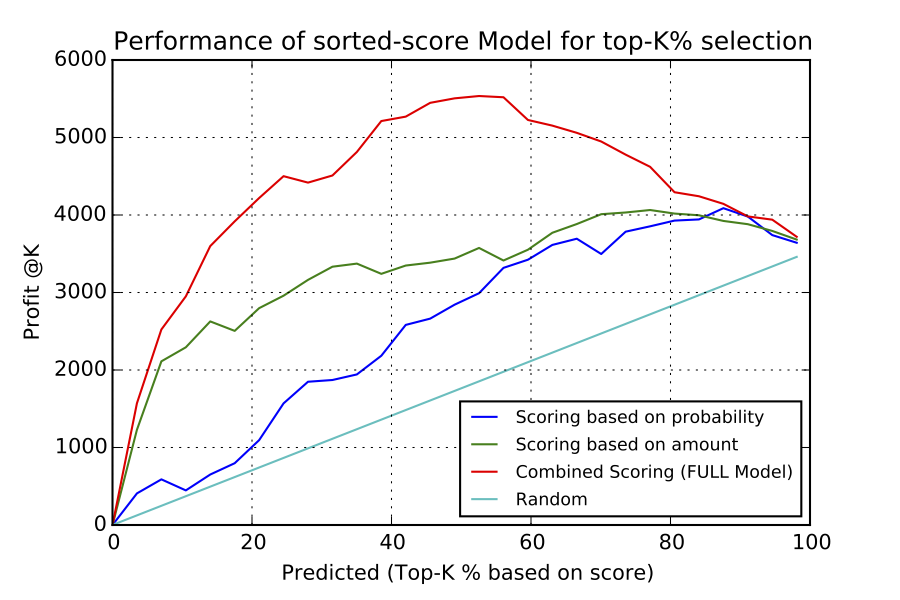

In [13]:
# PLOT: Display business-metric performance on test-set